# Scenario Object Tutorial
---

This is a quick tutorial to guide the user through the functionalities of the scenario object. Note that a scenario has various state. So far the **analyze** and **create** states have been implemented. The **execute** state comes next. One argument is needed to create a Scenario instance: a string. Different instances will be created depending on the string passed to the Scenario object:
* empty string --> **create** state;
* scenario name or scenario id --> **execute** or **analyze** states depending on what information is found in the scenario list file (a table dfining the characteristics of each scenarion that is is read and written by the Scenario object) on the server.

Other states will be implemented in the futre. A **delete** and **modify** states will be useful. The current status of the Scenario object is shown below.
![Scenario Workflow](scenario.jpg)

## Analyze State
Let's see what happens when the scenario name or id passed as argument is not found in the scenario list file on the server.

In [1]:
from powersimdata.scenario.scenario import Scenario

In [2]:
scenario = Scenario('dummy')

------------------
SCENARIO NOT FOUND
------------------
id   plan         name        interconnect base_demand base_hydro base_solar base_wind
0  base    original           Western      v3          v1         v2         v1      
1  ca2045  ca2020             Western      ca2020      v1         v2         v1      
2  ca2045  ca2020FixCaCong    Western      ca2020      v1         v2         v1      
3  ca2045  ca2020FixWestCong  Western      ca2020      v1         v2         v1      
4  ca2045  ca2020WestTarget   Western      ca2020      v1         v2         v1      
5  ca2045  ca2030             Western      ca2030      v1         v2         v1      
6  ca2045  ca2030FixCaCong    Western      ca2030      v1         v2         v1      
7  ca2045  ca2030FixWestCong  Western      ca2030      v1         v2         v1      
8  ca2045  ca2030WestTarget   Western      ca2030      v1         v2         v1


It prints the list of available scenarios. Note that the scenario id is unique while the scenario name is only unique for a given plan - interconnect combination. If there are multiple scenario sharing the same name in the scenario list file then the above summary will be returned and the user will be asked to provide the identification number in order to select a scenario.

Let's now pick a scenario that exists.

In [3]:
scenario = Scenario('3')

SCENARIO: ca2045 | ca2020FixWestCong 

# Loading ct
--> Done loading

# Loading Western interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading branch
--> Done loading


This scenario instance is in the **analyze** state. Note that it is possible to switch state. The **delete** state is accessible.

In [4]:
print("State name: %s" % scenario.state.name)
print("Allowed state: %s" % scenario.state.allowed)

State name: analyze
Allowed state: ['delete']


The scenario description can easily be accessed.

In [5]:
scenario.print_scenario_info()

--------------------
SCENARIO INFORMATION
--------------------
id: 3
plan: ca2045
name: ca2020FixWestCong
status: 2
interconnect: Western
base_demand: ca2020
base_hydro: v1
base_solar: v2
base_wind: v1
change_table: Yes
start_index: 0
end_index: 60
interval: 144H
start_date: 2016-01-01 00:00:00
end_date: 2016-12-31 23:00:00
runtime: 9:08
infeasibilities: 35:5_36:5


When a Scenario instance is created, the change table and grid are automatically loaded. Changes found in the change table are applied to the grid. This means that the capacity of some generators and/or transmission lines will be scaled. The grid used for this scenario can be accessed as follows:

In [6]:
grid = scenario.state.get_grid()
grid.plant.head(n=10)

,bus_id,Pg,Qg,Qmax,Qmin,Vg,mBase,status,Pmax,Pmin,...,mu_Qmax,mu_Qmin,GenMWMax,GenMWMin,type,interconnect,lat,lon,zone_id,zone_name
plant_id,,,,,,,,,,,,,,,,,,,,,
10390,2010683,0.00,0.00,61.16,-7.80,1.0464,207.74,0,159.27,52.01,...,0.0,0.0,159.270000,52.010000,hydro,Western,46.6451,-119.9080,201,Washington
10391,2010684,85.29,56.74,61.16,-7.80,1.0201,201.13,1,85.29,85.29,...,0.0,0.0,159.266663,32.410946,hydro,Western,46.6451,-119.9080,201,Washington
10392,2010685,138.65,56.74,61.16,-7.80,1.0201,217.36,1,138.65,138.65,...,0.0,0.0,159.266663,56.056601,hydro,Western,46.6451,-119.9080,201,Washington
10393,2010686,0.00,0.00,61.16,-7.80,1.0464,214.15,0,159.27,56.04,...,0.0,0.0,159.266663,56.038070,hydro,Western,46.6451,-119.9080,201,Washington
10394,2010687,120.63,56.74,61.16,-7.80,1.0188,188.08,1,120.63,120.63,...,0.0,0.0,159.266663,39.988425,hydro,Western,46.6451,-119.9080,201,Washington
10395,2010688,109.93,56.74,61.16,-7.80,1.0206,201.28,1,109.93,109.93,...,0.0,0.0,159.266663,19.930100,hydro,Western,46.6451,-119.9080,201,Washington
10396,2010689,9.02,4.95,4.95,-0.63,1.0014,12.90,1,9.02,9.02,...,0.0,0.0,12.899999,1.998092,hydro,Western,46.6451,-119.9080,201,Washington
10397,2010691,59.72,21.07,21.07,-14.24,1.0061,98.92,1,59.72,59.72,...,0.0,0.0,98.900002,16.648942,wind,Western,45.8131,-120.3475,201,Washington
10398,2010694,23.02,5.33,13.44,-1.71,1.0493,35.08,1,23.02,23.02,...,0.0,0.0,34.999999,3.838867,hydro,Western,46.4661,-122.1097,201,Washington


And the change table:

In [7]:
ct = scenario.state.get_ct()
print(ct)

{'solar': {'zone_id': {203: 1.52, 204: 1.52, 205: 1.52, 206: 1.52, 207: 1.52}}, 'wind': {'zone_id': {203: 1.48, 204: 1.48, 206: 1.48, 207: 1.48}}, 'branch': {'branch_id': {88258: 2, 88270: 2, 89167: 2, 89181: 2, 89240: 2, 89242: 2, 89335: 2, 89339: 2, 89756: 2, 90143: 2, 90240: 2, 90323: 2, 90349: 2, 90350: 2, 90353: 2, 90373: 2, 90395: 2, 90415: 2, 90630: 2, 90696: 2, 91031: 2, 91117: 2, 91161: 2, 91770: 2, 91965: 2, 92043: 2, 92103: 2, 92675: 2, 92676: 2, 93157: 2, 93215: 2, 93280: 2, 93525: 2, 93812: 2, 93887: 2, 93929: 2, 93932: 2, 94027: 2, 94030: 2, 94032: 2, 94046: 2, 94065: 2, 94068: 2, 94095: 2, 94102: 2, 94137: 2, 94140: 2, 94222: 2, 94224: 2, 94225: 2, 94226: 2, 94323: 2, 94342: 2, 94481: 2, 94529: 2, 94549: 2, 94820: 2, 95277: 2, 95316: 2, 95407: 2, 95414: 2, 95474: 2, 95501: 2, 95521: 2, 95522: 2, 95594: 2, 95614: 2, 95629: 2, 95633: 2, 95773: 2, 95966: 2, 95971: 2, 95987: 2, 95991: 2, 95997: 2, 96009: 2, 96023: 2, 96162: 2, 96464: 2, 96938: 2, 96963: 2, 97059: 2, 97072: 2

One can sees that the capacity of solar and wind generators in load zones 203, 204, 205, 206 and 207 have been increased by 1.52 and 1.48, respectively. Also, the capacity of some transmission lines has bee increased by a factor 2. In this case the identification number of the branch has been used. The mapping load zone id to load zone name is accessible via the Grid object.

In [8]:
grid.zone

{201: 'Washington',
 202: 'Oregon',
 203: 'Northern California',
 204: 'Bay Area',
 205: 'Central California',
 206: 'Southwest California',
 207: 'Southeast California',
 208: 'Nevada',
 209: 'Arizona',
 210: 'Utah',
 211: 'New Mexico',
 212: 'Colorado',
 213: 'Wyoming',
 214: 'Idaho',
 215: 'Montana',
 216: 'El Paso'}

Those are the 16 load zones of the Western Interconnect. One can sees that only the solar and wind generators in California have been scaled. Let's take a look at the transmission lines in the change table:

In [9]:
grid.branch.loc[ct['branch']['branch_id'].keys()]

,from_bus_id,to_bus_id,r,x,b,rateA,rateB,rateC,ratio,angle,...,mu_angmax,interconnect,from_lat,from_lon,to_lat,to_lon,from_zone_id,to_zone_id,from_zone_name,to_zone_name
branch_id,,,,,,,,,,,,,,,,,,,,,
88258,2010033,2010045,0.010951,0.047533,0.03427,432.80,0,0,0.00000,0.0,...,0.0,Western,46.127668,-123.010999,46.339390,-122.809116,201,201,Washington,Washington
88270,2010045,2010041,0.005713,0.037310,0.01199,473.12,0,0,0.00000,0.0,...,0.0,Western,46.339390,-122.809116,46.418666,-122.895750,201,201,Washington,Washington
89167,2010690,2010691,0.003387,0.099890,0.00000,257.14,0,0,1.06250,0.0,...,0.0,Western,45.813100,-120.347500,45.813100,-120.347500,201,201,Washington,Washington
89181,2010702,2010703,0.002458,0.078799,0.00000,354.38,0,0,1.00000,0.0,...,0.0,Western,45.879700,-120.807200,45.879700,-120.807200,201,201,Washington,Washington
89240,2010862,2010740,0.001157,0.011576,0.68304,2258.28,0,0,0.00000,0.0,...,0.0,Western,46.534700,-122.424700,46.060833,-122.201667,201,201,Washington,Washington
89242,2010745,2010746,0.003229,0.108939,0.00000,234.00,0,0,1.00000,0.0,...,0.0,Western,46.954700,-120.181900,46.954700,-120.181900,201,201,Washington,Washington
89335,2010820,2010821,0.001925,0.061021,0.00000,393.12,0,0,1.00000,0.0,...,0.0,Western,45.921500,-120.235500,45.921500,-120.235500,201,201,Washington,Washington
89339,2013591,2010823,0.004927,0.031697,0.04237,388.78,0,0,0.00000,0.0,...,0.0,Western,45.716700,-120.200800,45.921500,-120.235500,202,201,Oregon,Washington
89756,2013100,2013198,0.006014,0.027242,0.09078,375.14,0,0,0.00000,0.0,...,0.0,Western,44.759860,-123.098768,44.509368,-122.912774,202,202,Oregon,Oregon


Where do these lines start and end?

In [10]:
for line in ct['branch']['branch_id'].keys():
    print("#%d: %s --> %s" % (line, grid.branch.loc[line].from_zone_name, grid.branch.loc[line].to_zone_name))

#88258: Washington --> Washington
#88270: Washington --> Washington
#89167: Washington --> Washington
#89181: Washington --> Washington
#89240: Washington --> Washington
#89242: Washington --> Washington
#89335: Washington --> Washington
#89339: Oregon --> Washington
#89756: Oregon --> Oregon
#90143: Oregon --> Oregon
#90240: Oregon --> Oregon
#90323: Oregon --> Oregon
#90349: Oregon --> Oregon
#90350: Oregon --> Oregon
#90353: Oregon --> Oregon
#90373: Oregon --> Oregon
#90395: Oregon --> Oregon
#90415: Oregon --> Oregon
#90630: Northern California --> Northern California
#90696: Northern California --> Northern California
#91031: Northern California --> Northern California
#91117: Northern California --> Northern California
#91161: Northern California --> Northern California
#91770: Bay Area --> Bay Area
#91965: Bay Area --> Bay Area
#92043: Bay Area --> Bay Area
#92103: Bay Area --> Bay Area
#92675: Central California --> Central California
#92676: Central California --> Central Cal

Input profiles and output data can be loaded as follows. If the file is not found locally, then it will be downloaded from the server.

In [11]:
wind = scenario.state.get_wind()
wind.head(n=10)

# Loading wind
--> Done loading


,10397,10400,10401,10428,10442,10458,10463,10475,10522,10541,...,12781,12794,12795,12796,12810,12811,12821,12822,12851,12853
UTC,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,33.909546,48.626080,51.586488,23.288450,24.722452,2.797636,30.861675,39.982030,19.645964,25.497791,...,1.537407,104.988481,9.695788,9.595831,4.768569,5.298409,7.203523,7.203523,102.031051,187.616487
2016-01-01 01:00:00,44.784148,36.054589,57.629619,18.203596,13.542212,6.911965,39.535177,39.244850,18.829837,31.653611,...,3.845821,106.481712,9.696933,9.596964,8.460214,9.400238,8.365460,8.365460,103.482219,188.972294
2016-01-01 02:00:00,40.734996,18.561881,52.191783,20.425524,16.816121,11.194243,39.297413,24.722842,16.544856,27.673932,...,3.740176,106.496834,9.698210,9.598228,8.983049,9.981165,9.284972,9.284972,103.496915,188.999999
2016-01-01 03:00:00,50.635387,20.275974,73.058373,29.439972,4.268782,10.527046,49.774332,43.521291,23.969048,32.047304,...,5.370021,106.500006,9.696742,9.596776,8.999180,9.999089,9.952833,9.952833,103.499997,188.999999
2016-01-01 04:00:00,53.228489,9.405172,84.871384,28.126471,0.725327,7.316950,55.562933,45.677556,27.052540,34.383732,...,9.226200,106.500006,9.666699,9.567042,8.980537,9.978374,9.972236,9.972236,103.499997,188.999999
2016-01-01 05:00:00,53.190699,21.428189,105.827933,31.319637,0.000000,7.191513,57.142437,44.205780,27.893860,36.189522,...,8.137596,106.500006,9.648035,9.548570,8.998466,9.998296,9.919974,9.919974,103.499997,188.999999
2016-01-01 06:00:00,55.095836,3.919431,23.580001,0.499303,14.604772,104.764732,0.000000,60.652748,0.077259,10.185377,...,13.024827,106.500006,9.697329,0.042406,8.717807,0.658001,0.377748,8.953696,90.712877,186.657566
2016-01-01 07:00:00,42.425082,19.660461,102.088990,15.474583,3.696718,13.950800,51.786974,23.712260,18.476934,35.471641,...,10.380569,106.500006,9.700000,9.600000,8.994836,9.994262,9.996891,9.996891,103.499997,188.999999
2016-01-01 08:00:00,33.334598,7.434749,90.665434,13.261137,9.221730,16.439985,43.057870,21.683408,15.181028,35.555042,...,9.227584,106.500006,9.699966,9.599966,8.996322,9.995913,9.998542,9.998542,103.499997,188.999999


Let's take a look at infeasibilities. These are period where demand were decreased by some amout in order to make the optimization problem solvable.

In [12]:
scenario.state.print_infeasibilities()

demand in 2016-07-29 00:00:00 - 2016-08-04 00:00:00 interval has been reduced by 5%
demand in 2016-08-04 00:00:00 - 2016-08-10 00:00:00 interval has been reduced by 5%


Below, we plot the original demand profile along with the reduced one for Washington State.

# Loading demand
--> Done loading
# Loading demand
--> Done loading


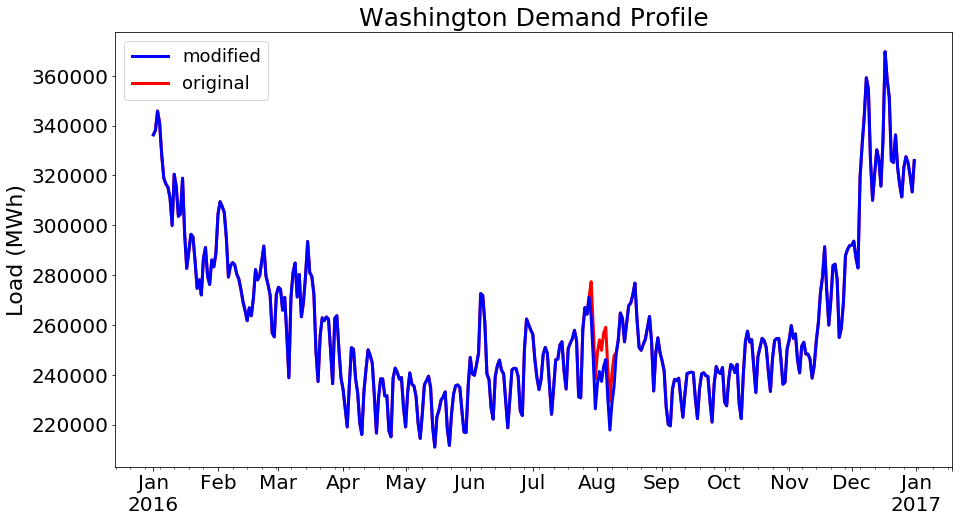

Original demand: 95246910 (MWh)
Reduced demand: 95095571 (MWh)


In [13]:
import matplotlib.pyplot as plt

zone = 201
demand_original = scenario.state.get_demand()
demand_modified = scenario.state.get_demand(original=False)

fig = plt.figure(figsize=(15, 8))
plt.title("%s Demand Profile" % grid.zone[201], fontsize=25)
ax = fig.gca()
ax.grid(color='black', axis='y')
ax.tick_params(which='both', labelsize=20)
ax = demand_original[zone].rename('original').resample('D').sum().plot(ax=ax, color='red', legend=True, lw=3)
ax = demand_modified[zone].rename('modified').resample('D').sum().plot(ax=ax, color='blue', legend=True, lw=3)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], frameon=2, prop={'size': 18})
ax.set_xlabel('')
ax.set_ylabel('Load (MWh)', fontsize=22)
plt.show()

print("Original demand: %d (MWh)" % demand_original[201].sum())
print("Reduced demand: %d (MWh)" % demand_modified[zone].sum())

## Create State
Let's create a scenario now!

In [14]:
new_scenario = Scenario('')
print("State name: %s" % new_scenario.state.name)
print("Allowed state: %s" % new_scenario.state.allowed)

State name: create
Allowed state: []


In [15]:
new_scenario.print_scenario_info()

--------------------
SCENARIO INFORMATION
--------------------
plan: 
name: 
status: 0
interconnect: 
base_demand: 
base_hydro: 
base_solar: 
base_wind: 
change_table: No
start_index: 0
end_index: 60
interval: 144H
start_date: 2016-01-01 00:00:00
end_date: 2016-12-31 23:00:00


To create a scenario, one needs to set the interconnect, base_demand, base_hydro, base_solar and base_wind profiles version and, optionally, scale the capacity of generators and/or transmission lines. Let's do so.

In [16]:
from powersimdata.scenario.create import Western

new_scenario.state.set_builder(Western())

# Loading Western interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading branch
--> Done loading

# Existing study
base | ca2045 

# Available profiles
demand: ca2020 | ca2030 | v3
hydro: v1
solar: v2
wind: v1


The Western interconnect is loaded and the already existing plan for the Western interconnect are given. Also a list of the available profiles for the chosen interconnect is printed. Let's name our scenario.

In [17]:
new_scenario.state.builder.set_name('ca2045', 'ca2020')

Combination ca2045 - ca2020 already exists


Oops, we can't do that. Let's pick a dirrent name for our new scenario.

In [18]:
new_scenario.state.builder.set_name('ca2045', 'dummy')

Is that time to create the scenario?

In [19]:
new_scenario.state.create_scenario()

-------------------
MISSING INFORMATION
-------------------
base_demand
base_hydro
base_solar
base_wind


Nope. We still need to set the base profiles and eventually a change table.

In [20]:
new_scenario.state.builder.set_base_profile('demand', 'v3')
new_scenario.state.builder.set_base_profile('hydro', 'v1')
new_scenario.state.builder.set_base_profile('solar', 'v2')
new_scenario.state.builder.set_base_profile('wind', 'v1')

And increase the capacity of wind farms in Wisconsin.

In [21]:
new_scenario.state.builder.change_table.scale_plant_capacity('wind', {'Winsconsin': 5})

--------------
Possible zones
--------------
Washington
Oregon
Northern California
Bay Area
Central California
Southwest California
Southeast California
Nevada
Arizona
Utah
New Mexico
Colorado
Wyoming
Idaho
Montana
El Paso


Right, Wisconsin is not part of the Western interconnect. Let's consider Washington State then.

In [22]:
new_scenario.state.builder.change_table.scale_plant_capacity('wind', {'Washington': 5})
new_scenario.state.builder.change_table.ct

{'wind': {'zone_id': {201: 5}}}

Let's create the scenario now.

In [23]:
new_scenario.state.create_scenario()

CREATING SCENARIO: ca2045 | dummy 

--> Add entry in scenario table on server
--> Write change table on local machine
Write /Users/brdo/scenario_data/9_ct.pkl
--> Upload change table to server
Transferring /Users/brdo/scenario_data/9_ct.pkl to server
--> Create links to base profiles on server
--> Add entry in execute table on server

SCENARIO SUCCESSFULLY CREATED WITH ID #9


In [24]:
new_scenario.state.allowed

['delete', 'execute']